In [2]:
import distribution_modules as dm
import density_estimation_modules as dem
import classification_modules as cm
import importlib

importlib.reload(dm)
importlib.reload(dem)
importlib.reload(cm)

<module 'classification_modules' from 'C:\\Users\\shfar\\Desktop\\SU\\Thesis\\thesis\\classification_modules.py'>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# set configurations
sample_size = 50
nr_sample = 50
num_steps = 10
x_b = np.linspace(0,1,num_steps)

n_folds = 5

### Bounded distributions

In [17]:
bounded_dists = dm.get_bounded_distribution()
bounded_samples = dm.get_samples(bounded_dists, nr_sample, sample_size)
#dm.plot_histograms_of_samples(bounded_samples)

In [18]:
kde_df = dem.get_kde(bounded_samples, x_b)
kde_df.head(3)

,0,1,2,3,4,5,6,7,8,9,label
0,0.686630,0.825218,0.773016,0.670057,0.655532,0.745904,0.880938,0.982599,0.941817,0.698139,arcsine
1,0.695824,0.954610,1.063781,1.018918,0.909212,0.799639,0.683756,0.616361,0.625455,0.559462,arcsine
2,0.806827,0.902286,0.787528,0.679815,0.711060,0.822235,0.886095,0.864824,0.765198,0.563403,arcsine


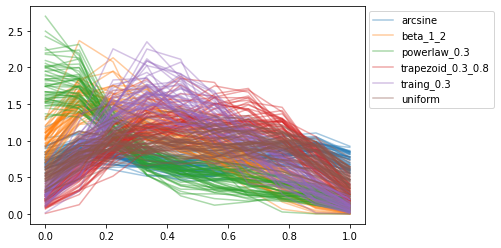

In [19]:
dem.get_kde_plot(kde_df,x_b)

### SVM

In [7]:
sample_size_list = [5, 10, 50, 100, 500, 1000]
num_steps_list = list(np.arange(1,21))

In [8]:
res_svm = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, bounded_dists, nr_sample, n_folds, 'kde', 1)

% completed:   0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
res_svm.to_csv('results/kde/res_svm_bounded.csv')

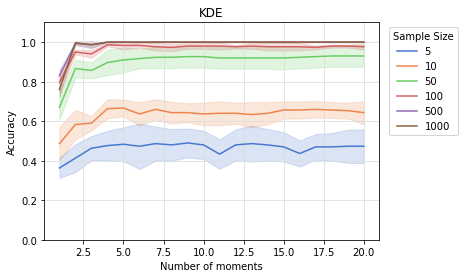

In [15]:
cm.plot_cv_numsteps_samplesize(res_svm,'KDE')

### Logistic Regression

In [16]:
res_lr = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, bounded_dists, nr_sample, n_folds, 'kde', 2)

% completed:   0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
res_lr.to_csv('results/kde/res_lr_bounded.csv')

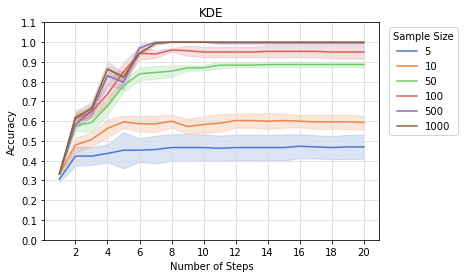

In [30]:
cm.plot_cv_numsteps_samplesize(res_lr,'KDE')

### Heavytail distributions

In [19]:
heavytail_dists = dm.get_heavytail_distribution()
heavytail_samples = dm.get_samples(heavytail_dists, nr_sample, sample_size, transform=True)
#dm.plot_histograms_of_samples(heavytail_samples)

In [20]:
perc_95 = np.percentile(heavytail_samples.iloc[:,:-1],95)
x_h = np.linspace(0,perc_95,num_steps)
kde_df = dem.get_kde(heavytail_samples, x_h)
kde_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,label
0,0.341617,0.366444,0.390977,0.414988,0.438259,0.460587,0.481788,0.501702,0.520197,0.537171,...,0.069810,0.066444,0.063253,0.060250,0.057447,0.054850,0.052456,0.050260,0.048247,cauchy
1,0.382405,0.402719,0.422977,0.443073,0.462894,0.482328,0.501260,0.519573,0.537155,0.553891,...,0.061462,0.059045,0.056722,0.054498,0.052376,0.050359,0.048450,0.046651,0.044965,cauchy
2,0.397802,0.421512,0.444604,0.466899,0.488233,0.508462,0.527466,0.545150,0.561444,0.576306,...,0.072586,0.068880,0.065112,0.061303,0.057477,0.053659,0.049877,0.046157,0.042527,cauchy


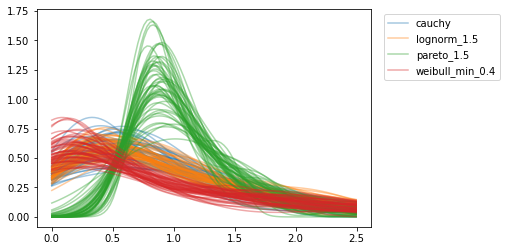

In [21]:
dem.get_kde_plot(kde_df,x_h)

### SVM

In [22]:
res_svm_ht = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, bounded_dists, nr_sample, n_folds, 'kde', 1, transform=True)

% completed:   0%|          | 0/6 [00:00<?, ?it/s]

In [23]:
res_svm_ht.to_csv('results/kde/res_svm_heavytail.csv')

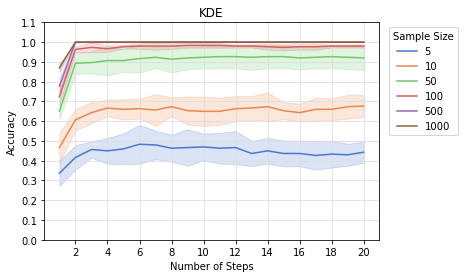

In [26]:
cm.plot_cv_numsteps_samplesize(res_svm_ht,'KDE')

### Logististic Regression

In [28]:
res_lr_ht = cm.cv_numsteps_samplesize(sample_size_list, num_steps_list, heavytail_dists, nr_sample, n_folds, 'kde', 2, transform = True)

% completed:   0%|          | 0/6 [00:00<?, ?it/s]

In [38]:
res_lr_ht.to_csv('results/kde/res_lr_heavytail.csv')

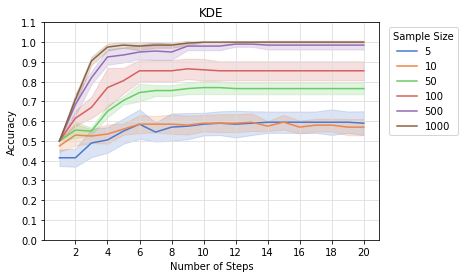

In [29]:
cm.plot_cv_numsteps_samplesize(res_lr_ht,'KDE')